In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import warnings
from privacygan import privacy_gan as pg
from privacygan.mnist import mnist_gan
from datetime import datetime

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__, "device:", device)


/data/miniconda/envs/privGAN/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.4.1 device: cpu


### Load dataset 

In [2]:
# Load MNIST data and concatenate the train+test set using torchvision
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

X_train = (train_ds.data.float() - 127.5) / 127.5
X_test = (test_ds.data.float() - 127.5) / 127.5
X_train = X_train.view(X_train.size(0), -1).numpy()
X_test = X_test.view(X_test.size(0), -1).numpy()
X_all = np.concatenate((X_train, X_test))

# Generate training/test split
frac = 0.1
n = int(frac * len(X_all))
idx = np.random.permutation(len(X_all))
X = X_all[idx[:n]]
X_comp = X_all[idx[n:]]

print('training set size:', X.shape)
print('test set size:', X_comp.shape)


training set size: (7000, 784)
test set size: (63000, 784)


### Test Simple GAN 

In [3]:
(generator, discriminator, dLosses, gLosses) = pg.SimpGAN(X, epochs=1, batchSize=256)

Epochs: 1
Batch size: 256
Batches per epoch: 27
epoch = 1/1, d_loss=1.247, g_loss=0.6742, g_loss=0.796


In [4]:
#perform white box attack
Acc = pg.WBattack(X,X_comp, discriminator)

White-box attack accuracy: 0.10485714285714286


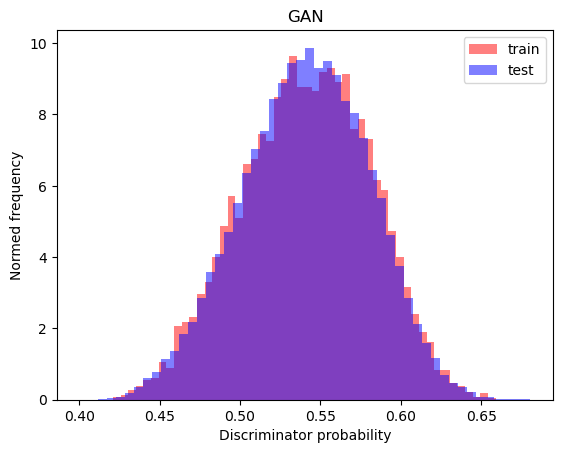

In [5]:
with torch.no_grad():
    scores_train = discriminator(torch.tensor(X, dtype=torch.float32, device=device)).cpu().numpy().squeeze()
    scores_test = discriminator(torch.tensor(X_comp, dtype=torch.float32, device=device)).cpu().numpy().squeeze()

plt.hist(scores_train, color='r', alpha=0.5, label='train', density=True, bins=50)
plt.hist(scores_test, color='b', alpha=0.5, label='test', density=True, bins=50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('GAN')
plt.legend()


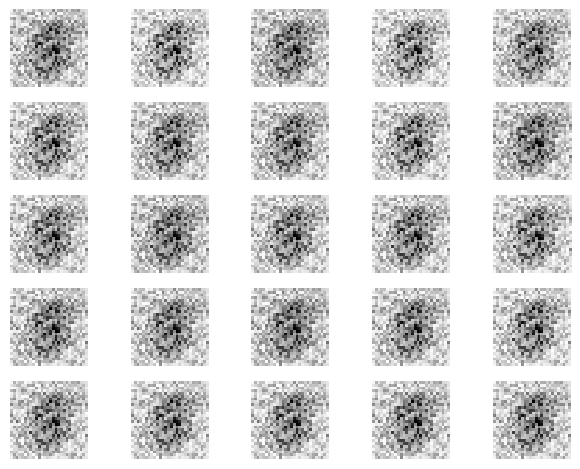

In [6]:
#Generate fake images
pg.DisplayImages(generator, figSize=(5,5), NoImages = 25)

### Test privGAN

In [7]:
### Test privGAN (with n_reps = 2)
generators = [mnist_gan.MNIST_Generator(), mnist_gan.MNIST_Generator()]
discriminators = [mnist_gan.MNIST_Discriminator(), mnist_gan.MNIST_Discriminator()]
pDisc = mnist_gan.MNIST_DiscriminatorPrivate(OutSize=2)

(generators, discriminators, _, dLosses, dpLosses, gLosses) = pg.privGAN(
    X,
    epochs=1,
    disc_epochs=1,
    batchSize=256,
    generators=generators,
    discriminators=discriminators,
    pDisc=pDisc,
    privacy_ratio=1.0,
)


dp-Accuracy: 0.524
Epochs: 1
Batch size: 256
Batches per epoch: 13
epoch = 0/1, batch = 13/13
dLosses = [1.10244595 1.10728181]
dpLosses = 0.0
gLosses = 2.6491956619115977
dp-Accuracy: 0.5


In [8]:
#perform white box attack
pg.WBattack_priv(X,X_comp, discriminators)

White-box attack accuracy (max): 0.09871428571428571
White-box attack accuracy (mean): 0.09714285714285714


(0.09871428571428571, 0.09714285714285714)

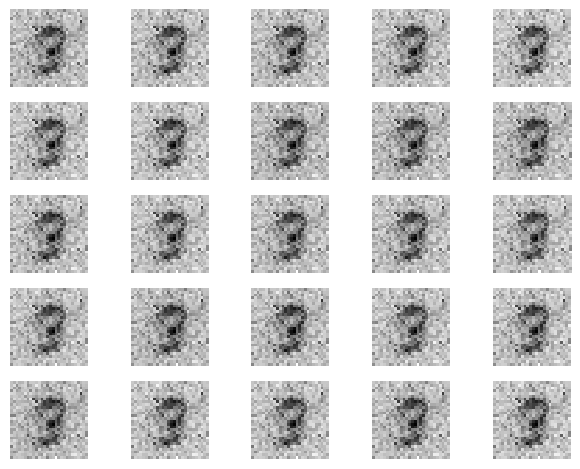

In [9]:
#Generate fake images
pg.DisplayImages(generators[1], figSize=(5,5), NoImages = 25)

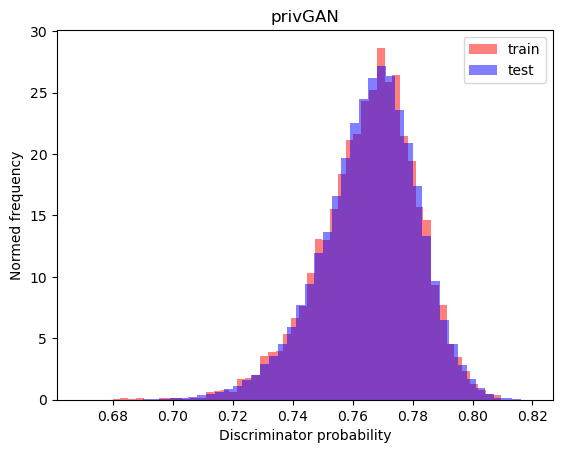

In [10]:
with torch.no_grad():
    scores_train = discriminators[0](torch.tensor(X, dtype=torch.float32, device=device)).cpu().numpy().squeeze()
    scores_test = discriminators[0](torch.tensor(X_comp, dtype=torch.float32, device=device)).cpu().numpy().squeeze()

plt.hist(scores_train, color='r', alpha=0.5, label='train', density=True, bins=50)
plt.hist(scores_test, color='b', alpha=0.5, label='test', density=True, bins=50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('privGAN')
plt.legend()
